# Regression with target log transformed
This notebook explains a bit how hyperparameter finetuning is done for predicting log(max price).
## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
df =pd.read_csv('train.csv')




## Feature engineering
Do all manipulations on the data.

In [2]:
# Drop rows where ''screen_surface', 'weight' and 'detachable_keyboard' has a missing value
df.dropna(subset=['screen_surface'], how='any', inplace=True)
df.dropna(subset=['detachable_keyboard'], how='any', inplace=True)
df.dropna(subset=['weight'], how='any', inplace=True)


df=df.drop(columns=['pixels_y'])
df=df.drop(columns=['name'])
df=df.drop(columns=[ 'os_details'])
df=df.drop(columns=[ 'cpu_details'])
df=df.drop(columns=[ 'base_name'])
df=df.drop(columns=[ 'gpu'])
df=df.drop(columns=[ 'id'])


countries = df['brand']
country_counts = countries.value_counts()
mask = df['brand'].isin(country_counts[country_counts < 9].index)
# Label all other categories as Other
df['brand'][mask] = 'Other1'

countries = df['cpu']
country_counts = countries.value_counts()
mask = df['cpu'].isin(country_counts[country_counts < 9].index.drop('Intel Core i9'))
# Label all other categories as Other1
df['cpu'][mask] = 'Other1'
mask=df['cpu'].isin(['Intel Pentium','AMD A6'])
df['cpu'][mask] = 'Other1'


df['screen_surface']=df['screen_surface'].str.lower()
df=pd.get_dummies(df, columns=['screen_surface'], drop_first=True, prefix='DM')
df=pd.get_dummies(df, columns=['os'], drop_first=True, prefix='DM')
df=pd.get_dummies(df, columns=['brand'], drop_first=True, prefix='DM')
df=pd.get_dummies(df, columns=['cpu'], drop_first=True, prefix='DM')

<ipython-input-2-53f173d18cfa>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['brand'][mask] = 'Other1'
<ipython-input-2-53f173d18cfa>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cpu'][mask] = 'Other1'
<ipython-input-2-53f173d18cfa>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cpu'][mask] = 'Other1'


In [3]:
X=df.drop(columns=['min_price', 'max_price'])
y=df['max_price'].apply(np.log) ##take logtransformation of max price

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

## Random forest

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train,y_train)

# Look at the R^2 scores on train and test
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))


0.9793679673502483
0.8942933008904675


### Hyperparameter tuning using cross validation

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3,5,9], 'max_features': [4,8,12,10], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    #rfr.fit(X_train, y_train)
    cv_scores = cross_val_score(rfr, X_train, y_train, cv=5,scoring='neg_mean_absolute_error') # change possibly to 'r2'
    test_scores.append(np.mean(cv_scores))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.1918573796182424 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 9}


### Test on test set

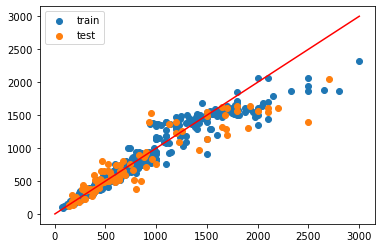

0.9636681176643439
0.8880573284166362
MAE_train is 97.45134849317597
MAE_test is 154.60177412420123


In [20]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=9, max_features=8, random_state=42)
rfr.fit(X_train, y_train)

# Make predictions with our model
train_predictions = np.exp(rfr.predict(X_train))
test_predictions = np.exp(rfr.predict(X_test))

# Create a scatter plot with train and test actual vs predictions

plt.scatter(np.exp(y_train), train_predictions, label='train')
plt.scatter(np.exp(y_test), test_predictions, label='test')
plt.plot([4, 3000],[4, 3000], color='red')
plt.legend()
plt.show()

print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

print("MAE_train is {}".format(mean_absolute_error(np.exp(y_train),  train_predictions)))
print("MAE_test is {}".format(mean_absolute_error(np.exp(y_test),  test_predictions)))

### Feature importance

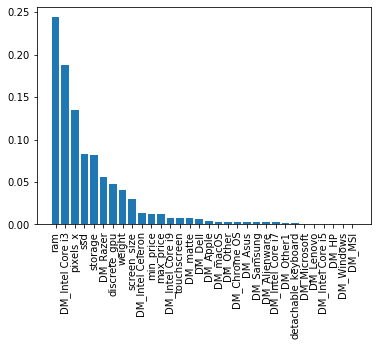

In [7]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(df.columns)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## Gradient boosting

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(X_train,y_train)

print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.8259932239834515
0.795741177704073


### Hyperparameter tuning using cross validation

In [9]:
# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'learning_rate': [0.01,0.05,0.1], 'max_features': [10, 4,6,8], 'subsample':[0.6,0.4,0.2,0.8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    gbr.set_params(**g)  # ** is "unpacking" the dictionary
    #gbr.fit(X_train, y_train)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5,scoring='neg_mean_absolute_error') # change possibly to 'r2'
    test_scores.append(np.mean(cv_scores))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])


-0.19760916959910207 {'subsample': 0.8, 'random_state': 42, 'n_estimators': 200, 'max_features': 10, 'learning_rate': 0.05}


In [21]:
grid = {'n_estimators': [200], 'learning_rate': [0.05,0.1], 'max_features': [10,6,8], 'subsample':[0.2,0.8], 'random_state': [42]}
# Instantiate gbr
gbr = GradientBoostingRegressor()
# Instantiate the GridSearchCV object: gbr_cv
gbr_cv = GridSearchCV(gbr, grid, cv=5, scoring='neg_mean_absolute_error')
# Fit it to the data
gbr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

### Test on test set

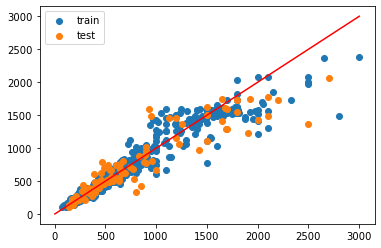

0.9394568263962918
0.8811402647767173
MAE_train is 116.26530483809415
MAE_test is 159.5590182501287


In [24]:
# Create GB model
gbr = GradientBoostingRegressor(max_features=10,
                                learning_rate=0.05,
                                n_estimators=200,
                                subsample=0.8,
                                random_state=42)
gbr.fit(X_train,y_train)


# Make predictions with our model
train_predictions = np.exp(gbr.predict(X_train))
test_predictions = np.exp(gbr.predict(X_test))

# Create a scatter plot with train and test actual vs predictions

plt.scatter(np.exp(y_train), train_predictions, label='train')
plt.scatter(np.exp(y_test), test_predictions, label='test')
plt.plot([4, 3000],[4, 3000], color='red')
plt.legend()
plt.show()

print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

print("MAE_train is {}".format(mean_absolute_error(np.exp(y_train),  train_predictions)))
print("MAE_test is {}".format(mean_absolute_error(np.exp(y_test),  test_predictions)))

### Feature importance

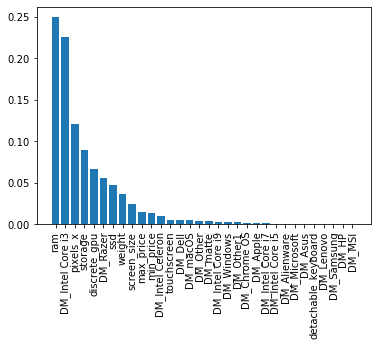

In [11]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(df.columns)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## Cross validation

In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rfr, X, y, cv=5,scoring='neg_mean_absolute_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-0.18136869 -0.2077089  -0.18679804 -0.21281929 -0.18807284]
Average 5-Fold CV Score: -0.19535355337770333


In [14]:
cv_scores = cross_val_score(gbr, X, y, cv=5,scoring='neg_mean_absolute_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-0.18321524 -0.22359669 -0.19055957 -0.22194757 -0.20186391]
Average 5-Fold CV Score: -0.20423659613485473


In [15]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
grid = {'n_estimators': [200], 'learning_rate': [0.01,0.05,0.1], 'max_features': [10, 4,6,8], 'subsample':[0.6,0.4,0.2,0.8], 'random_state': [42]}

# Instantiate a logistic regression classifier: logreg
gbr = GradientBoostingRegressor()


# Instantiate the GridSearchCV object: logreg_cv
gbr_cv = GridSearchCV(gbr, grid, cv=5, scoring='neg_mean_absolute_error')

# Fit it to the data
gbr_cv.fit(X_train,y_train)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Logistic Regression Parameters: {'learning_rate': 0.05, 'max_features': 10, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}
Best score is -0.19760916959910207


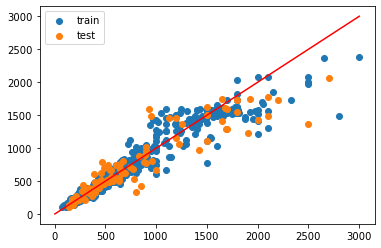

0.9394568263962918
0.8811402647767173
MAE_train is 116.26530483809415
MAE_test is 159.5590182501287


In [19]:

gbr.set_params(**gbr_cv.best_params_)
gbr.fit(X_train,y_train)
train_predictions = np.exp(gbr.predict(X_train))
test_predictions = np.exp(gbr.predict(X_test))

# Create a scatter plot with train and test actual vs predictions

plt.scatter(np.exp(y_train), train_predictions, label='train')
plt.scatter(np.exp(y_test), test_predictions, label='test')
plt.plot([4, 3000],[4, 3000], color='red')
plt.legend()
plt.show()

print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

print("MAE_train is {}".format(mean_absolute_error(np.exp(y_train),  train_predictions)))
print("MAE_test is {}".format(mean_absolute_error(np.exp(y_test),  test_predictions)))